# World Wide Evolution

The following maps are interactive and they aren't able to be seen in github. In order to see and explore them you can acess the next link: https://nbviewer.jupyter.org/github/isasilva3/Epidemiologia/blob/master/World%20Wide/Maps%20and%20Time%20series%20plots.ipynb

In [1]:
!pip install cufflinks
!pip install folium

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150 #set figure size

from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import plotly.graph_objs as go
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import folium
df = pd.read_csv("../Datasets/WW/covid_19_data.csv")
df.rename(columns={'Country/Region':'Country'}, inplace=True)
df = df.drop(columns = ['SNo', "Last Update"]) #only confuses

df_conf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_conf.rename(columns={'Country/Region':'Country'}, inplace=True)

df_death = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_death.rename(columns={'Country/Region':'Country'}, inplace=True)
countries = pd.read_csv("../Datasets/WW/countries_by_population_2019.csv")
countries_iso = pd.read_csv("../Datasets/WW/country_codes_2020.csv")


Confirmed cases, deaths and recovered by coutry, province/state for each date.

In [3]:
df.sample(5)

,ObservationDate,Province/State,Country,Confirmed,Deaths,Recovered
28198,05/23/2020,NaN,Portugal,30471.0,1302.0,7705.0
28135,05/23/2020,NaN,Guinea-Bissau,1114.0,6.0,42.0
26321,05/18/2020,Valle d'Aosta,Italy,1174.0,143.0,971.0
18968,04/27/2020,NaN,Andorra,743.0,40.0,385.0
16617,04/19/2020,French Guiana,France,96.0,0.0,64.0


Confirmed cases, deaths, population, cases per million inhabitants and deaths per million inhabitants by country.

In [4]:
df['Country'] = df['Country'].str.strip()

df.loc[df['Province/State'].isnull(), 'Province/State'] = df.loc[df['Province/State'].isnull(), 'Country']

df.sort_values(['Country', 'Province/State', 'ObservationDate'], ascending = [True,True,False], inplace = True)
df = df.drop_duplicates(['Country', 'Province/State'], keep = "first")

df_state = df.copy()

df = df.drop(columns = "ObservationDate")

df_country = df.groupby(['Country'], as_index=False)['Confirmed', 'Deaths'].sum()

cols_to_drop = ['Rank', 'pop2018','GrowthRate', 'area', 'Density']
countries = countries.drop(columns = cols_to_drop)

countries = countries.merge(countries_iso[['name', 'cca3']], on = ['name'], how = "left")

cols_to_rename = {'name': 'Country', 'pop2019': 'Population', 'cca3': 'ISO'}
countries = countries.rename(columns = cols_to_rename)

countries_to_rename = {'US': 'United States',\
                       'Mainland China': 'China',\
                       'UK': 'United Kingdom',\
                       'Congo (Kinshasa)': 'DR Congo',\
                       'North Macedonia': 'Macedonia',\
                       'Republic of Ireland': 'Ireland',\
                       'Congo (Brazzaville)': 'Republic of the Congo'}

df_country['Country'] = df_country['Country'].replace(countries_to_rename)

df_country = df_country.merge(countries, on = "Country", how = "left")

df_country = df_country.dropna()

df_country['Population'] = round((df_country['Population']/1000),2)
df_country = df_country.rename(columns = {'Population': 'Population (million)'})
df_country['Cases per Million'] = round((df_country['Confirmed']/df_country['Population (million)']),2)
df_country['Deaths per Million'] = round((df_country['Deaths']/df_country['Population (million)']),2)

df_country = df_country[(df_country['Population (million)'] > 1)]

df_country.sample(5)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Country,Confirmed,Deaths,Population (million),ISO,Cases per Million,Deaths per Million
96,Iran,148950.0,7734.0,82.91,IRN,1796.53,93.28
187,Spain,467919.0,54229.0,46.74,ESP,10011.10,1160.23
48,Cuba,2025.0,83.0,11.33,CUB,178.73,7.33
210,United Arab Emirates,33896.0,262.0,9.77,ARE,3469.40,26.82
45,DR Congo,2966.0,69.0,86.79,COD,34.17,0.80


# Top 10 countries with most confirmed cases

In [5]:
df_country = df_country.sort_values(['Cases per Million'], ascending = False).reset_index(drop=True)
df_country.drop(columns = ['ISO', 'Deaths', 'Deaths per Million']).head(10).style.background_gradient(cmap='Reds', subset = ['Cases per Million'])

,Country,Confirmed,Population (million),Cases per Million
0,Qatar,55262.000000,2.830000,19527.210000
1,Spain,467919.000000,46.740000,10011.100000
2,Peru,291576.000000,32.510000,8968.810000
3,Chile,144437.000000,18.950000,7622.010000
4,Italy,454768.000000,60.550000,7510.620000
5,Bahrain,10793.000000,1.640000,6581.100000
6,Kuwait,26192.000000,4.210000,6221.380000
7,Singapore,34366.000000,5.800000,5925.170000
8,United States,1770853.000000,329.060000,5381.550000
9,Ireland,24929.000000,4.880000,5108.400000


# World map with cases per million inhabitants by country

In [6]:
fig = px.choropleth(df_country, locations="ISO",
                    color="Cases per Million",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.YlOrRd)

layout = go.Layout(
    title=go.layout.Title(
        text="Corona confirmed cases per million inhabitants",
        x=0.5
    ),
    font=dict(size=14),
    width = 750,
    height = 350,
    margin=dict(l=0,r=0,b=0,t=30)
)

fig.update_layout(layout)

fig.show()

#plt.savefig('../Images/WorldMapCases.png')


# Top 10 countries with most deaths

In [7]:
df_country = df_country.sort_values(['Deaths per Million'], ascending = False).reset_index(drop=True)
countries = df_country.copy()

df_country.drop(columns = ['ISO', 'Confirmed', 'Cases per Million']).head(10).style.background_gradient(cmap='Reds', subset = ['Deaths per Million'])

,Country,Deaths,Population (million),Deaths per Million
0,Spain,54229.000000,46.740000,1160.230000
1,Italy,64446.000000,60.550000,1064.340000
2,Belgium,9453.000000,11.540000,819.150000
3,United Kingdom,38691.000000,67.530000,572.950000
4,France,28774.000000,65.130000,441.790000
5,Sweden,4395.000000,10.040000,437.750000
6,Netherlands,5970.000000,17.100000,349.120000
7,Ireland,1651.000000,4.880000,338.320000
8,United States,103799.000000,329.060000,315.440000
9,Peru,8354.000000,32.510000,256.970000


# World map with deaths per million inhabitants by country

In [8]:
fig = px.choropleth(df_country, locations="ISO",
                    color="Deaths per Million",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.YlOrRd)

layout = go.Layout(
    title=go.layout.Title(
        text="Corona deaths per million inhabitants",
        x=0.5
    ),
    font=dict(size=14),
    width = 750,
    height = 350,
    margin=dict(l=0,r=0,b=0,t=30)
)

fig.update_layout(layout)

fig.show()

# Bubble Maps

# World bubble map with confirmed cases by province/state

In [9]:
cols_to_select = list(df_conf.columns[0:4]) + list(df_conf.columns[-6:])
df_conf.loc[(df_conf['Country'] == "Netherlands"), cols_to_select]

,Province/State,Country,Lat,Long,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20
166,Aruba,Netherlands,12.5186,-70.0358,101,101,101,101,101,101
167,Curacao,Netherlands,12.1696,-68.9900,18,18,18,19,19,19
168,Sint Maarten,Netherlands,18.0425,-63.0548,77,77,77,77,77,77
169,NaN,Netherlands,52.1326,5.2913,45768,45950,46126,46257,46442,46545
255,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,6,6,6,6,6,7


In [10]:
cols_to_keep = list(df_conf.columns[0:4]) + list(df_conf.columns[-1:])
df_conf_last = df_conf[cols_to_keep]
df_conf_last.columns.values[-1] = "Confirmed"

df_conf_last.head()

,Province/State,Country,Lat,Long,Confirmed
0,NaN,Afghanistan,33.0000,65.0000,15750
1,NaN,Albania,41.1533,20.1683,1143
2,NaN,Algeria,28.0339,1.6596,9513
3,NaN,Andorra,42.5063,1.5218,765
4,NaN,Angola,-11.2027,17.8739,86


In [11]:
df_conf_last['Confirmed'] = df_conf_last['Confirmed'].astype(float)

map1 = folium.Map(location=[30.6, 114], zoom_start=3) #US=[39,-98] Europe =[45, 5]

for i in range(0,len(df_conf_last)):
   folium.Circle(
      location=[df_conf_last.iloc[i]['Lat'], df_conf_last.iloc[i]['Long']],
      tooltip = "Country: "+df_conf_last.iloc[i]['Country']+"<br>Province/State: "+str(df_conf_last.iloc[i]['Province/State'])+"<br>Confirmed cases: "+str(df_conf_last.iloc[i]['Confirmed'].astype(int)),
      radius=df_conf_last.iloc[i]['Confirmed']*5,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(map1)

map1

# World bubble map with deaths by province/state

In [12]:
cols_to_keep = list(df_death.columns[0:4]) + list(df_death.columns[-1:])
df_death_last = df_death[cols_to_keep]
df_death_last.columns.values[-1] = "Death"

df_death_last['Death'] = df_death_last['Death'].astype(float)

map2 = folium.Map(location=[30.6, 114], zoom_start=3)

for i in range(0,len(df_death_last)):
   folium.Circle(
      location=[df_death_last.iloc[i]['Lat'], df_death_last.iloc[i]['Long']],
      tooltip = "Country: "+df_death_last.iloc[i]['Country']+"<br>Province/State: "+str(df_death_last.iloc[i]['Province/State'])+"<br>Deaths: "+str(df_death_last.iloc[i]['Death'].astype(int)),
      radius=df_death_last.iloc[i]['Death']*100,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(map2)

map2

# Time series plots

# Confirmed cases of the most affected countries

In [18]:
ts_country = df_conf.drop(columns = ['Lat', 'Long', 'Province/State'])
ts_country = ts_country.groupby(['Country']).sum()
ts_country = ts_country.sort_values(by = ts_country.columns[-1], ascending = False).head(7)

ts_country.transpose().iplot(title = 'Time series of confirmed cases of countries with most confirmed cases')

plt.savefig('../Images/WorldStatics.png')

<Figure size 900x600 with 0 Axes>

# Deaths of countries with most victims

In [14]:
ts_country = df_death.drop(columns = ['Lat', 'Long', 'Province/State'])
ts_country = ts_country.groupby(['Country']).sum()

ts_country = ts_country.sort_values(by = ts_country.columns[-1], ascending = False).head(7)
ts_country.drop(ts_country.columns[len(ts_country.columns)-1], axis=1, inplace=True)

ts_country.transpose().iplot(title = 'Time series of deaths of countries with most victims')


# Death trend since the first victim

In [15]:
ts_country = ts_country.transpose()

df1 = ts_country.iloc[:,0].to_frame()
df1 = df1[df1.iloc[:,0] !=0].reset_index(drop=True)

for i in range(1,ts_country.shape[1]):
    df = ts_country.iloc[:,i].to_frame()
    df = df[df.iloc[:,0] !=0].reset_index(drop=True)
    df1 = pd.concat([df1, df], join='outer', axis=1)

    
df1.iplot(title = 'Time series of deaths since first victim', xTitle = 'Days since first reported Death', yTitle = 'Number of Deaths')

# Confirmed cases vs. Deaths

Here we can see the countries that have the worst ratio of deaths relative to the number of confirmed cases.

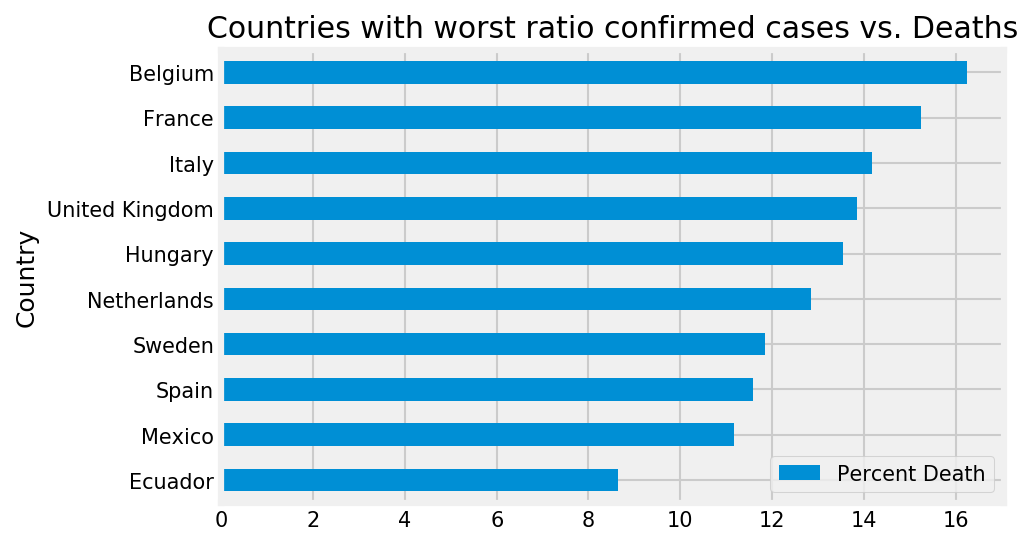

In [16]:
df_country = df_country.drop(columns = ['Population (million)', 'ISO', 'Cases per Million', 'Deaths per Million'])
df_country['Percent Death'] = round(((df_country.Deaths / df_country.Confirmed)*100),2)
df_country = df_country[(df_country.Deaths >= 100)]

se = df_country[['Country', 'Percent Death']].sort_values(by = "Percent Death", ascending = False).set_index("Country")
se = se[0:10].sort_values(by = "Percent Death", ascending = True)
se.plot.barh()
plt.title("Countries with worst ratio confirmed cases vs. Deaths")
plt.xticks(rotation=0);

Here we can see the countries that are doing the best when looking at the relation between the number of deaths and the number of confirmed cases.

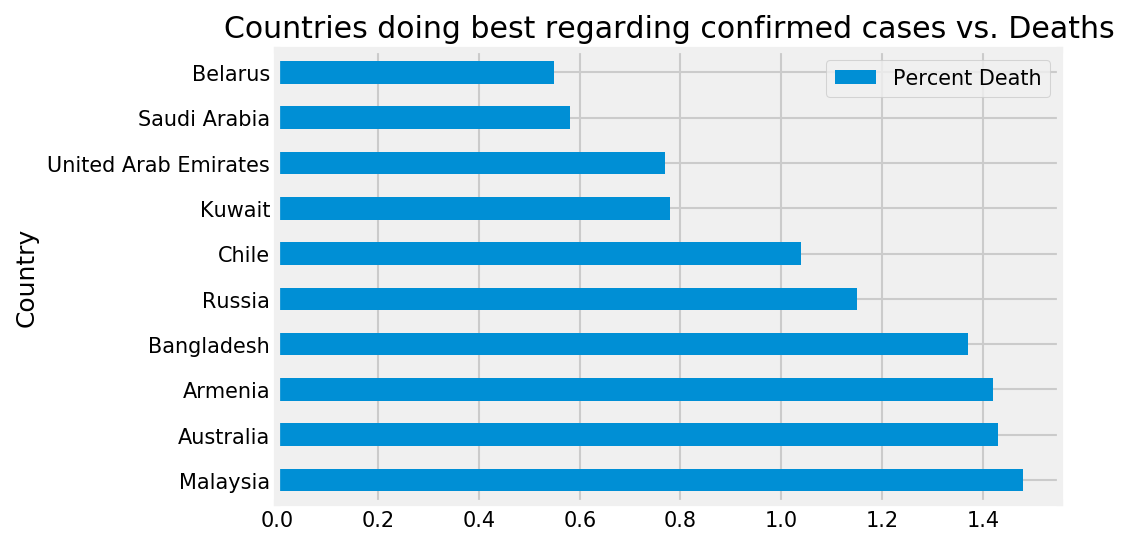

In [17]:
se = df_country[['Country', 'Percent Death']].sort_values(by = "Percent Death", ascending = False).set_index("Country")
se = se[-10:]
se.plot.barh()
plt.title("Countries doing best regarding confirmed cases vs. Deaths")
plt.xticks(rotation=0);